# 步骤2：使用HMMs进行数据标记
由于无法实时的获取到T5当前写的字母对应于哪些时间步，因此这里使用隐马尔可夫模型对数据进行标记。

In [1]:
import numpy as np
import scipy.io
import sys
sys.path.append("../handwritingBCI/") # 这样就可以引用其中的py文件
import os
import datetime
from characterDefinitions import getHandwritingCharacterDefinitions
from dataLabelingStep import labelDataset, constructRNNTargets

rootDir =  '../handwritingBCI/handwritingBCIData/'
dataDirs = ['t5.2019.05.08','t5.2019.11.25','t5.2019.12.09','t5.2019.12.11','t5.2019.12.18',
            't5.2019.12.20','t5.2020.01.06','t5.2020.01.08','t5.2020.01.13','t5.2020.01.15']
res_root = rootDir+"cache/RNNTrainingSteps/Step2_HMMLabels/"
twc_root = rootDir+'cache/RNNTrainingSteps/Step1_TimeWarping/'
hlb_path = rootDir+'cache/RNNTrainingSteps/trainTestPartitions_HeldOutBlocks.mat'
hlt_path = rootDir+'cache/RNNTrainingSteps/trainTestPartitions_HeldOutTrials.mat'
charDef = getHandwritingCharacterDefinitions()
if not os.path.isdir(res_root):
    os.makedirs(res_root)  # 注意不使用mkdir, 因为是多层目录

## HMMs Labeling
### 1. 数据说明
### 1-1. 语句字典
`'__header__', '__version__', '__globals__'`: 文件信息。     
`'neuralActivityCube'`, 三维数据张量S(sentences) T(time steps) N(electrodes) (102, 10669, 192). 注意它可以从`neuralActivityTimeSeries`完全被重构出来，并且时间步使用用时最多的句子（因此其他的会有冗余），变量`numTimeBinsPerSentence`记录了每个句子的真实时间步数。    
`'sentencePrompt'`, 字符串数组。显示在屏幕上的句子，可能包含#>?等等字符  
`'intendedText'`, 字符串数组，与`sentencePrompt`相同，除非是#(表停顿，去掉）以及自由书写等等  
`'numTimeBinsPerSentence'`, 其中的元素i表示第i个句子持续的时间步数  
`'sentenceCondition'`, 表示第i个句子的实验条件，例如提词复写、带随机停顿的提词复写等等  
`'sentenceBlockNums'`, 记录句子i时的块号  
`'excludedSentences'`, 值为0或者1，为1时表示该句子作废（例如T5错误的拼写，不想写这个，等等），不可用于分析。  
`'neuralActivityTimeSeries'`, 对所有192个电极和所有10毫秒时间步的数据进行分组的尖峰计数的时间序列。注意，每当块号发生变化时，时间序列中就会出现不连续的中断(在块之间记录的神经活动没有被保存)。  
`'clockTimeSeries'`, 10ms的时间步    
`'blockNumsTimeSeries'`, 10ms的时间步，记录对应的块号  
`'blockList'`, 可用的块号列表。    
`'blockStartDates'`, 每一块的起始时间，精确到秒，可用于计算两个块间隔时长。     
`'goCueOnsetTimeBin'`, 第i号元素表示第i次实验中go指令对应的时间步序号。     
`'delayCueOnsetTimeBin'`, 停等周期的起始时间步序号。  
`'sentenceEndTimeBin'`, T5结束句子书写的时间步号。  
`arrayGeometryMap`,   
`rnn_charProbTimeSeries`,RNN解码器每10毫秒时间步输出的字符概率的时间序列。在实时解码器未激活的块期间输出等于零。  
`rnn_newCharTimeSeries`, RNN解码器每10毫秒时间步输出的新字符信号的时间序列。该信号被设定阈值(阈值= 0.3)，以确定在实时解码过程中何时输出新字符。  
`rnn_decodedCharTimes`, 一个矩阵，其中每一行i对应一个被RNN解码的字符。第1列表示该字符被解码时的时间步，第2列表示哪个字符被解码  
`rnn_decodedText`,  i号实验的解码结果文本  
`rnn_charMapASCII`, 字符映射  


`labelDataset()`返回值:    
`letterStarts` (matrix : N x 200) 字符起始时间步, 每一行代表个句子  
`letterDurations` (matrix : N x 200): 每个字符持续的时间步数，每一行表示一个句子  
`neuralCube` (matrix : N x T x E): 一个规则的平滑的神经活动数据 (N = # of sentences, T = # of time steps, E = # of electrodes)   
`blankWindows` (list): A nested list of time windows where periods of 'blank' pauses occur in the data. This is used to extract 'blank' snippets for simulating pauses. 

`constructRNNTargets()`返回值:   
`charStartTarget`(matrix : N x T): A matrix containing the character start signal target for each sentence.   
`charProbTarget`(matrix : N x T x 31): A matrix of timestep-by-timestep character probability targets for all 31 characters (one-hot encoding)   
`gnoreErrorHere`(matrix : N x T): A matrix that specifies which time steps to ignore when training the RNN (1 = ignore). We use this feature to prevent the RNN from being pnealized for errors that occur at the very start of the trial, before T5 has written any character yet (if the HMM has labeled this as a 'blank' state).

In [ ]:
def run():
    for dataDir in dataDirs:
        timeStart = datetime.datetime.now()
        print('Labeling ' + dataDir + ' dataset')
        #load sentences, single letter, time-warped files, and train/test partitions
        sentenceDat = scipy.io.loadmat(rootDir+'Datasets/'+dataDir+'/sentences.mat')
        singleLetterDat = scipy.io.loadmat(rootDir+'Datasets/'+dataDir+'/singleLetters.mat')
        twCubes = scipy.io.loadmat(twc_root+dataDir+'_warpedCubes.mat')
        cvPart_heldOutBlocks = scipy.io.loadmat(hlb_path)
        cvPart_heldOutTrials = scipy.io.loadmat(hlt_path)
        cvParts = [cvPart_heldOutBlocks, cvPart_heldOutTrials]
        # 去掉句子中的#号
        for x in range(sentenceDat['sentencePrompt'].shape[0]):
            sentenceDat['sentencePrompt'][x,0][0] = sentenceDat['sentencePrompt'][x,0][0].replace('#','')
        cvFolderNames = ['HeldOutBlocks', 'HeldOutTrials']
        sentences = sentenceDat['sentencePrompt'][:,0]
        sentenceLens = sentenceDat['numTimeBinsPerSentence'][:,0]
        # 对每一个实验部分进行标记
        for cvPart, cvFolder in zip(cvParts, cvFolderNames):
            print("Labeling '" + cvFolder + "' partition")
            trainPartitionIdx = cvPart[dataDir+'_train']
            testPartitionIdx = cvPart[dataDir+'_test']
            llb = labelDataset(sentenceDat, singleLetterDat, twCubes, 
                               trainPartitionIdx, testPartitionIdx, charDef)
            letterStarts, letterDurations, blankWindows = llb
            cci = constructRNNTargets(letterStarts, letterDurations, 
                                      sentenceDat['neuralActivityCube'].shape[1], 
                                      sentences, charDef)
            charStartTarget, charProbTarget, ignoreErrorHere = cci
            saveDict = {}
            saveDict['letterStarts'] = letterStarts
            saveDict['letterDurations'] = letterDurations
            saveDict['charStartTarget'] = charStartTarget.astype(np.float32)
            saveDict['charProbTarget'] = charProbTarget.astype(np.float32)
            saveDict['ignoreErrorHere'] = ignoreErrorHere.astype(np.float32)
            saveDict['blankWindows'] = blankWindows
            saveDict['timeBinsPerSentence'] = sentenceDat['numTimeBinsPerSentence']
            if not os.path.isdir(res_root+cvFolder):
                os.mkdir(res_root+cvFolder)
            scipy.io.savemat(res_root+cvFolder+'/'+dataDir+'_timeSeriesLabels.mat', saveDict)
        timeEnd = datetime.datetime.now()
        print('Total time taken: ' + str((timeEnd - timeStart).total_seconds()) + ' seconds')
        print(' ')
run()

Labeling t5.2019.05.08 dataset
Labeling 'HeldOutBlocks' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Labeling 'HeldOutTrials' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Total time taken: 2144.131006 seconds
 
Labeling t5.2019.11.25 dataset
Labeling 'HeldOutBlocks' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Labeling 'HeldOutTrials' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Total time taken: 4936.452962 seconds
 
Labeling t5.2019.12.09 dataset
Labeling 'HeldOutBlocks' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Labeling 'HeldOutTrials' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Total time taken: 1397.336474 seconds
 
Labeling t5.2019.12.11 dataset
Labeling 'HeldOutBlocks' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Labeling 'HeldOutTrials' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Total time taken: 1089.029927 seconds
 
Labeling t5.2019.12.18 dataset
Labeling 'HeldOutBlocks' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Labeling 'HeldOutTrials' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Total time taken: 1176.388896 seconds
 
Labeling t5.2019.12.20 dataset
Labeling 'HeldOutBlocks' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Labeling 'HeldOutTrials' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Total time taken: 1088.006955 seconds
 
Labeling t5.2020.01.06 dataset
Labeling 'HeldOutBlocks' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Labeling 'HeldOutTrials' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Total time taken: 789.429435 seconds
 
Labeling t5.2020.01.08 dataset
Labeling 'HeldOutBlocks' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Labeling 'HeldOutTrials' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Total time taken: 875.16205 seconds
 
Labeling t5.2020.01.13 dataset
Labeling 'HeldOutBlocks' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Labeling 'HeldOutTrials' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Total time taken: 292.62443 seconds
 
Labeling t5.2020.01.15 dataset
Labeling 'HeldOutBlocks' partition
HMM Iteration 0
HMM Iteration 1


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Labeling 'HeldOutTrials' partition
HMM Iteration 0
HMM Iteration 1
Total time taken: 331.43229 seconds
 


C:\Users\mrrai\.conda\envs\tf115\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [6]:
sdt, twc, cvp = run()

Labeling t5.2019.05.08 dataset


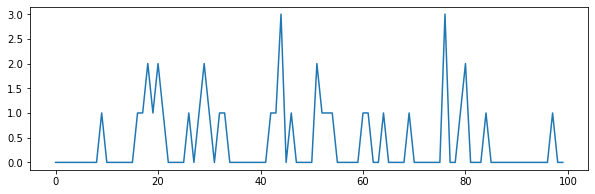

In [16]:
import matplotlib.pyplot as plt
st1el1_ = sdt['neuralActivityCube'][0, :100,0]
plt.figure(figsize=(10, 3))
plt.plot(list(range(len(st1el1_))), st1el1_)
plt.show()

In [22]:
sdt["sentencePrompt"].shape, sdt["sentencePrompt"][0, 0]

((102, 1), array(['thanks>so>much,>honey~'], dtype='<U22'))

In [23]:
sdt["intendedText"].shape, sdt["intendedText"][0, 0]

((102, 1), array(['thanks>so>much,>honey~'], dtype='<U22'))

In [24]:
sdt["numTimeBinsPerSentence"].shape, sdt["numTimeBinsPerSentence"][0, 0]

((102, 1), 1961)

In [25]:
sdt["sentenceCondition"].shape, sdt["sentenceCondition"][0, 0]

((102, 1), array(['OL Copy'], dtype='<U7'))

In [27]:
sdt["sentenceBlockNums"].shape, sdt["sentenceBlockNums"][0, 0]

((102, 1), 6)

In [28]:
sdt["excludedSentences"].shape, sdt["excludedSentences"][0, 0]

((102, 1), 0)

In [29]:
sdt["neuralActivityTimeSeries"].shape

(599319, 192)

In [34]:
sdt["goCueOnsetTimeBin"].shape, sdt["goCueOnsetTimeBin"][0, 0]

((102, 1), 2734)

In [39]:
cvp[0]["t5.2019.11.25_train"]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]])

In [40]:
cvp[1]["t5.2019.11.25_train"]

array([[ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17,
        18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 30, 32, 35, 36, 37, 38,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 57, 59, 60, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76]])

In [48]:
for cvPrt, cvFld in zip(cvp, ['HeldOutBlocks', 'HeldOutTrials']):
    print("Labeling '" + cvFld + "' partition")
    print(cvPrt["t5.2019.11.25_train"])

Labeling 'HeldOutBlocks' partition
[[ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
  25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]]
Labeling 'HeldOutTrials' partition
[[ 0  1  2  3  4  6  7  8  9 10 11 13 14 15 16 17 18 19 20 22 23 24 25 26
  27 28 30 32 35 36 37 38 40 41 42 43 44 45 46 47 48 49 57 59 60 62 63 64
  65 66 67 68 69 70 71 73 74 75 76]]


In [51]:
dd = "t5.2019.05.08"
std = scipy.io.loadmat(rootDir+'Datasets/'+dd+'/sentences.mat')
sld = scipy.io.loadmat(rootDir+'Datasets/'+dd+'/singleLetters.mat')
twcb = scipy.io.loadmat(twc_root+dd+'_warpedCubes.mat')
trpi = cvp[0][dd+'_train']
tepi = cvp[0][dd+'_test']
ls, ld, bw = labelDataset(std, sld, twcb, trpi, tepi, charDef)

HMM Iteration 0
HMM Iteration 1


In [64]:
ls.shape, ls[0, :5]

((102, 200), array([ 44., 159., 209., 304., 379.]))

In [65]:
ld.shape, ld[0, :5]

((102, 200),
 array([70.56428571, 50.25      , 79.28571429, 36.4       , 71.31428571]))

In [67]:
sentences = std['sentencePrompt'][:,0]
cci = constructRNNTargets(ls, ld, std['neuralActivityCube'].shape[1], 
                          sentences, charDef)
cstar, cptar, ieher = cci

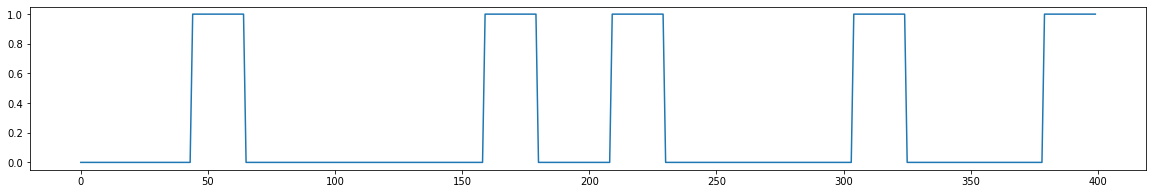

In [72]:
st1el1_ = cstar[0, :400]
plt.figure(figsize=(20, 3))
plt.plot(list(range(len(st1el1_))), st1el1_)
plt.show()

In [75]:
cptar.shape, cptar[0, 0, :]

((102, 10669, 31),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))